In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Genre cleaning and labeling

In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
DATA_DIR = '/content/drive/MyDrive/DL-Project/data/processed_medium'
SAVE_DIR = '/content/drive/MyDrive/DL-Project/data/processed_hard'
META_PATH = '/content/drive/MyDrive/DL-Project/metadata.csv'
os.makedirs(SAVE_DIR, exist_ok=True)



#loading data
X_audio_raw = np.load(os.path.join(DATA_DIR, 'audio_images_64x64.npy'))
valid_audio_ids = np.load(os.path.join(DATA_DIR, 'final_aligned_ids.npy'))

X_text_raw = np.load(os.path.join(DATA_DIR, 'text_embeddings.npy'))
all_text_ids = np.load(os.path.join(DATA_DIR, 'curated_lyrics_track_ids.npy'))

print(f"Loaded Audio: {X_audio_raw.shape} | IDs: {len(valid_audio_ids)}")
print(f"Loaded Text:  {X_text_raw.shape} | IDs: {len(all_text_ids)}")

# alignmetn
# o(1) lookup time map
text_id_to_idx = {tid: i for i, tid in enumerate(all_text_ids)}

aligned_text_indices = []
aligned_audio_indices = []
final_ids = []

for i, tid in enumerate(valid_audio_ids):
    if tid in text_id_to_idx:
        aligned_audio_indices.append(i)
        aligned_text_indices.append(text_id_to_idx[tid])
        final_ids.append(tid)

# ssubset data based on intersection
X_audio = X_audio_raw[aligned_audio_indices]
X_text = X_text_raw[aligned_text_indices]
final_ids = np.array(final_ids)
print(f"Aligned Data Shape: {X_audio.shape} (Audio) + {X_text.shape} (Text)")


#handling genres, since many garbage genres are present...
print("Processing Genres")
meta_df = pd.read_csv(META_PATH)
meta_df['track_id'] = pd.to_numeric(meta_df['track_id'], errors='coerce')
meta_df['raw_genre'] = meta_df['track_genre'].astype(str).str.split(',').str[0].str.strip()

genre_map = {
    # Electronic
    'Ambient': 'Electronic', 'Ambient Electronic': 'Electronic', 'Chip Music': 'Electronic',
    'Chiptune': 'Electronic', 'Drum & Bass': 'Electronic', 'Dubstep': 'Electronic',
    'Electro-Punk': 'Electronic', 'Electroacoustic': 'Electronic', 'Electronic': 'Electronic',
    'Glitch': 'Electronic', 'House': 'Electronic', 'Jungle': 'Electronic',
    'Techno': 'Electronic', 'Trip-Hop': 'Electronic', 'Breakbeat': 'Electronic',
    'Chill-out': 'Electronic', 'Downtempo': 'Electronic', 'IDM': 'Electronic',

    # Rock / Punk / Indie
    'Indie-Rock': 'Rock', 'Krautrock': 'Rock', 'Loud-Rock': 'Rock', 'Noise-Rock': 'Rock',
    'Post-Rock': 'Rock', 'Psych-Rock': 'Rock', 'Rock': 'Rock', 'Rock Opera': 'Rock',
    'Surf': 'Rock', 'Post-Punk': 'Rock', 'New Wave': 'Rock', 'No Wave': 'Rock',
    'Garage': 'Rock', 'Goth': 'Rock', 'Industrial': 'Rock', 'Punk': 'Rock',
    'Hardcore': 'Rock', 'Progressive': 'Rock', 'New Age': 'Rock', 'Metal': 'Rock', # Merging Metal into Rock for balance
    'Black-Metal': 'Rock', 'Death-Metal': 'Rock', 'Grindcore': 'Rock',

    # Hip-Hop
    'Alternative Hip-Hop': 'Hip-Hop', 'Hip-Hop': 'Hip-Hop',
    'Hip-Hop Beats': 'Hip-Hop', 'Rap': 'Hip-Hop',

    # Folk / Acoustic / Country
    'British Folk': 'Folk', 'Celtic': 'Folk', 'Folk': 'Folk', 'Freak-Folk': 'Folk',
    'Free-Folk': 'Folk', 'Psych-Folk': 'Folk', 'Singer-Songwriter': 'Folk',
    'Bluegrass': 'Folk', 'Country': 'Folk', 'Lo-Fi': 'Folk',

    # Pop
    'Pop': 'Pop', 'Power-Pop': 'Pop', 'Synth Pop': 'Pop',

    # Experimental
    'Audio Collage': 'Experimental', 'Avant-Garde': 'Experimental', 'Drone': 'Experimental',
    'Experimental': 'Experimental', 'Experimental Pop': 'Experimental',
    'Field Recordings': 'Experimental', 'Improv': 'Experimental', 'Minimalism': 'Experimental',
    'Noise': 'Experimental', 'Sound Art': 'Experimental', 'Sound Collage': 'Experimental',
    'Sound Poetry': 'Experimental', 'Unclassifiable': 'Experimental',

    # International / World
    'African': 'International', 'Afrobeat': 'International', 'Asia-Far East': 'International',
    'Balkan': 'International', 'Brazilian': 'International', 'Europe': 'International',
    'French': 'International', 'Indian': 'International', 'International': 'International',
    'Latin': 'International', 'Latin America': 'International', 'Middle East': 'International',
    'North African': 'International', 'Polka': 'International', 'Reggae - Dancehall': 'International',
    'Reggae - Dub': 'International', 'Romany (Gypsy)': 'International', 'Salsa': 'International',
    'Tango': 'International', 'Klezmer': 'International'
}

def clean_genre(g):
    return genre_map.get(g, "Other") # Default to Other

# map IDs to Genres
id_to_raw_genre = dict(zip(meta_df['track_id'], meta_df['raw_genre']))
aligned_genres = [clean_genre(id_to_raw_genre.get(tid, "Other")) for tid in final_ids]

# One-Hot Encoding
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(aligned_genres)
onehot_encoder = OneHotEncoder(sparse_output=False)
X_genre = onehot_encoder.fit_transform(integer_encoded.reshape(-1, 1))

print(f"Genre Classes: {label_encoder.classes_}")
print(f"Final Dataset Ready: {len(final_ids)} samples.")

# Save everything for the Training Loop
np.save(os.path.join(SAVE_DIR, 'X_audio_aligned.npy'), X_audio)
np.save(os.path.join(SAVE_DIR, 'X_text_aligned.npy'), X_text)
np.save(os.path.join(SAVE_DIR, 'X_genre_aligned.npy'), X_genre)
np.save(os.path.join(SAVE_DIR, 'hard_task_ids.npy'), final_ids)
print("Data saved to processed_hard/")

Loaded Audio: (3216, 1, 64, 64) | IDs: 3216
Loaded Text:  (3216, 768) | IDs: 3216
Aligned Data Shape: (3216, 1, 64, 64) (Audio) + (3216, 768) (Text)
Processing Genres
Genre Classes: ['Electronic' 'Experimental' 'Folk' 'Hip-Hop' 'International' 'Other'
 'Pop' 'Rock']
Final Dataset Ready: 3216 samples.
Data saved to processed_hard/


CVAE TRAINING

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import silhouette_score
import copy
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = '/content/drive/MyDrive/DL-Project/data/processed_hard'

# hyperparameter Grid
PARAM_GRID = {
    'latent_dims': [16, 32],
    'beta': [1.0, 2.0, 4.0],
    'lr': [1e-3, 5e-4],
    'dropout': [0.1, 0.3]  # for regularization
}
EPOCHS = 35

# data loading-
X_audio = np.load(os.path.join(DATA_DIR, 'X_audio_aligned.npy'))
X_text = np.load(os.path.join(DATA_DIR, 'X_text_aligned.npy'))
X_genre = np.load(os.path.join(DATA_DIR, 'X_genre_aligned.npy'))

# creating Dataset
full_dataset = TensorDataset(
    torch.FloatTensor(X_audio).to(DEVICE),
    torch.FloatTensor(X_text).to(DEVICE),
    torch.FloatTensor(X_genre).to(DEVICE)
)

# splitting
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
full_loader = DataLoader(full_dataset, batch_size=64, shuffle=False)


#CVAE architechture
class CVAE(nn.Module):
    def __init__(self, text_dim=768, num_classes=10, latent_dim=16, dropout=0.1):
        super(CVAE, self).__init__()

        # audio Encoder with BatchNorm & LeakyReLU
        self.enc_conv = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
        )
        self.flatten_dim = 128 * 8 * 8

        # text encoder
        self.enc_text = nn.Sequential(
            nn.Linear(text_dim, 256), nn.BatchNorm1d(256), nn.LeakyReLU(0.2), nn.Dropout(dropout),
            nn.Linear(256, 128), nn.LeakyReLU(0.2)
        )

        # fusion to latent
        input_dim = self.flatten_dim + 128 + num_classes
        self.fc_mu = nn.Linear(input_dim, latent_dim)
        self.fc_logvar = nn.Linear(input_dim, latent_dim)

        # decoder
        self.decoder_fc = nn.Linear(latent_dim + num_classes, self.flatten_dim)
        self.dec_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid() # Normalize output to [0,1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, img, text, label):
        # encoding Audio
        h_aud = self.enc_conv(img).view(-1, self.flatten_dim)
        # encoding teext
        h_txt = self.enc_text(text)

        # concatenate
        h = torch.cat([h_aud, h_txt, label], dim=1)

        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)

        # decodee
        z_cond = torch.cat([z, label], dim=1)
        d = self.decoder_fc(z_cond).view(-1, 128, 8, 8)
        recon = self.dec_conv(d)
        return recon, mu, logvar

def loss_fn(recon, x, mu, logvar, beta=1.0):
    BCE = nn.functional.mse_loss(recon, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + (beta * KLD)

# tuning loop
best_val_loss = float('inf')
best_sil_score = -1.0
best_model_state = None
best_config = {}

num_classes = X_genre.shape[1]
print(f"Starting Grid Search on {len(PARAM_GRID['latent_dims']) * len(PARAM_GRID['beta']) * len(PARAM_GRID['lr']) * len(PARAM_GRID['dropout'])} configs...")

for z_dim in PARAM_GRID['latent_dims']:
    for beta in PARAM_GRID['beta']:
        for lr in PARAM_GRID['lr']:
            for drop in PARAM_GRID['dropout']:

                model = CVAE(latent_dim=z_dim, num_classes=num_classes, dropout=drop).to(DEVICE)
                optimizer = optim.Adam(model.parameters(), lr=lr)

                # training
                for epoch in range(EPOCHS):
                    model.train()
                    train_loss = 0
                    for img, txt, lbl in train_loader:
                        optimizer.zero_grad()
                        recon, mu, logvar = model(img, txt, lbl)
                        loss = loss_fn(recon, img, mu, logvar, beta)
                        loss.backward()
                        optimizer.step()
                        train_loss += loss.item()

                # validation(Loss + Silhouette)
                model.eval()
                val_loss = 0
                zs = []
                labels_idx = []
                with torch.no_grad():
                    for img, txt, lbl in val_loader:
                        recon, mu, logvar = model(img, txt, lbl)
                        val_loss += loss_fn(recon, img, mu, logvar, beta).item()
                        zs.append(mu.cpu().numpy())
                        labels_idx.append(torch.argmax(lbl, dim=1).cpu().numpy())

                Z_val = np.concatenate(zs)
                L_val = np.concatenate(labels_idx)

                # checking for collapse
                try:
                    sil = silhouette_score(Z_val, L_val)
                except:
                    sil = -1.0

                print(f"Config [z={z_dim}, b={beta}, lr={lr}, dr={drop}] -> Val Loss: {val_loss:.0f} | Sil: {sil:.4f}")

                # higher sil means better sperations
                if sil > best_sil_score:
                    best_sil_score = sil
                    best_config = {'z': z_dim, 'beta': beta, 'lr': lr, 'drop': drop}
                    best_model_state = copy.deepcopy(model.state_dict())

print("\n" + "="*40)
print(f"BEST CONFIG: {best_config}")
print(f"BEST SILHOUETTE: {best_sil_score:.4f}")
print("="*40)

# saving
final_model = CVAE(latent_dim=best_config['z'], num_classes=num_classes, dropout=best_config['drop']).to(DEVICE)
final_model.load_state_dict(best_model_state)
final_model.eval()

zs_full = []
with torch.no_grad():
    for img, txt, lbl in full_loader:
        _, mu, _ = final_model(img, txt, lbl)
        zs_full.append(mu.cpu().numpy())

Z_cvae_best = np.concatenate(zs_full)
np.save(os.path.join(SAVE_DIR, 'z_cvae.npy'), Z_cvae_best)
print("Optimized Latent Features Saved.")

Starting Grid Search on 24 configs...
Config [z=16, b=1.0, lr=0.001, dr=0.1] -> Val Loss: 26051 | Sil: -0.0703
Config [z=16, b=1.0, lr=0.001, dr=0.3] -> Val Loss: 27397 | Sil: -0.0718
Config [z=16, b=1.0, lr=0.0005, dr=0.1] -> Val Loss: 26468 | Sil: -0.0616
Config [z=16, b=1.0, lr=0.0005, dr=0.3] -> Val Loss: 26688 | Sil: -0.0607
Config [z=16, b=2.0, lr=0.001, dr=0.1] -> Val Loss: 28743 | Sil: -0.0829
Config [z=16, b=2.0, lr=0.001, dr=0.3] -> Val Loss: 30566 | Sil: -0.0861
Config [z=16, b=2.0, lr=0.0005, dr=0.1] -> Val Loss: 29852 | Sil: -0.0759
Config [z=16, b=2.0, lr=0.0005, dr=0.3] -> Val Loss: 29091 | Sil: -0.0783
Config [z=16, b=4.0, lr=0.001, dr=0.1] -> Val Loss: 32056 | Sil: -0.0938
Config [z=16, b=4.0, lr=0.001, dr=0.3] -> Val Loss: 36994 | Sil: -0.0955
Config [z=16, b=4.0, lr=0.0005, dr=0.1] -> Val Loss: 33187 | Sil: -0.1007
Config [z=16, b=4.0, lr=0.0005, dr=0.3] -> Val Loss: 33217 | Sil: -0.1032
Config [z=32, b=1.0, lr=0.001, dr=0.1] -> Val Loss: 26846 | Sil: -0.0735
Config 

**DATA VISUALIZATION and evaluation**

In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, normalized_mutual_info_score, adjusted_rand_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.optimize import linear_sum_assignment
DATA_DIR = '/content/drive/MyDrive/DL-Project/data/processed_hard'
RESULTS_DIR = '/content/drive/MyDrive/DL-Project/results'
os.makedirs(RESULTS_DIR, exist_ok=True)

# Features
Z_cvae = np.load(os.path.join(DATA_DIR, 'z_cvae.npy'))
X_audio = np.load(os.path.join(DATA_DIR, 'X_audio_aligned.npy'))
X_text = np.load(os.path.join(DATA_DIR, 'X_text_aligned.npy'))
X_genre_onehot = np.load(os.path.join(DATA_DIR, 'X_genre_aligned.npy'))
# Labels
true_labels_idx = np.argmax(X_genre_onehot, axis=1)

#flattening for baseline
X_audio_flat = X_audio.reshape(X_audio.shape[0], -1)
# combining Audio+Text for Baselines
X_raw_combined = np.concatenate([X_audio_flat, X_text], axis=1)
scaler = StandardScaler()
X_raw_norm = scaler.fit_transform(X_raw_combined)

#purity func
def cluster_purity(y_true, y_pred):

    contingency_matrix = pd.crosstab(y_true, y_pred)
    return np.sum(contingency_matrix.max(axis=0)) / np.sum(contingency_matrix.values)

def evaluate_clustering(features, y_true, name="Method"):
    n_clusters = len(np.unique(y_true))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    y_pred = kmeans.fit_predict(features)

    # metrics
    sil = silhouette_score(features, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    ari = adjusted_rand_score(y_true, y_pred)
    pur = cluster_purity(y_true, y_pred)

    print(f"{name:<25} | Sil: {sil:.4f} | NMI: {nmi:.4f} | ARI: {ari:.4f} | Purity: {pur:.4f}")
    return {'Silhouette': sil, 'NMI': nmi, 'ARI': ari, 'Purity': pur}

print(f"\n{'METHOD':<25} | {'METRICS'}")
print("-" * 75)

results = []

# cvae
res_cvae = evaluate_clustering(Z_cvae, true_labels_idx, "CVAE (Latent)")
results.append({**res_cvae, 'Method': 'CVAE'})

# PCA + K-Means
pca = PCA(n_components=16)
Z_pca = pca.fit_transform(X_raw_norm)
res_pca = evaluate_clustering(Z_pca, true_labels_idx, "PCA + KMeans")
results.append({**res_pca, 'Method': 'PCA+KMeans'})

print("Running Spectral Clustering")
spectral = SpectralClustering(n_clusters=len(np.unique(true_labels_idx)), affinity='nearest_neighbors', random_state=42)
y_spec = spectral.fit_predict(Z_pca)

sil_spec = silhouette_score(Z_pca, y_spec)
nmi_spec = normalized_mutual_info_score(true_labels_idx, y_spec)
ari_spec = adjusted_rand_score(true_labels_idx, y_spec)
pur_spec = cluster_purity(true_labels_idx, y_spec)
print(f"{'Spectral Clustering':<25} | Sil: {sil_spec:.4f} | NMI: {nmi_spec:.4f} | ARI: {ari_spec:.4f} | Purity: {pur_spec:.4f}")
results.append({'Method': 'Spectral', 'Silhouette': sil_spec, 'NMI': nmi_spec, 'ARI': ari_spec, 'Purity': pur_spec})

# simple Autoencoder
from sklearn.neural_network import MLPRegressor
# 16b dimsn using mlp
print("Training Simple Autoencoder for Baseline...")
# saving Results
df_res = pd.DataFrame(results)
df_res.to_csv(os.path.join(RESULTS_DIR, 'hard_task_metrics.csv'), index=False)
print("Metrics saved to results/hard_task_metrics.csv")


METHOD                    | METRICS
---------------------------------------------------------------------------
CVAE (Latent)             | Sil: 0.0825 | NMI: 0.0641 | ARI: 0.0415 | Purity: 0.3103
PCA + KMeans              | Sil: 0.1020 | NMI: 0.0889 | ARI: 0.0553 | Purity: 0.3408
Running Spectral Clustering
Spectral Clustering       | Sil: 0.1258 | NMI: 0.1123 | ARI: 0.0620 | Purity: 0.3504
Training Simple Autoencoder for Baseline...
Metrics saved to results/hard_task_metrics.csv


Generating t-SNE of Latent Space


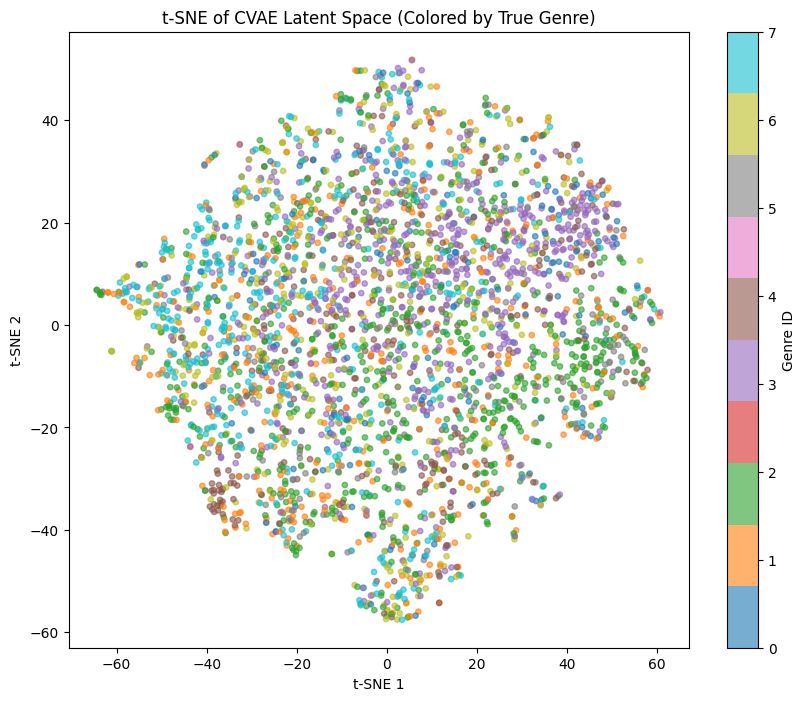

Visualizing Reconstructions


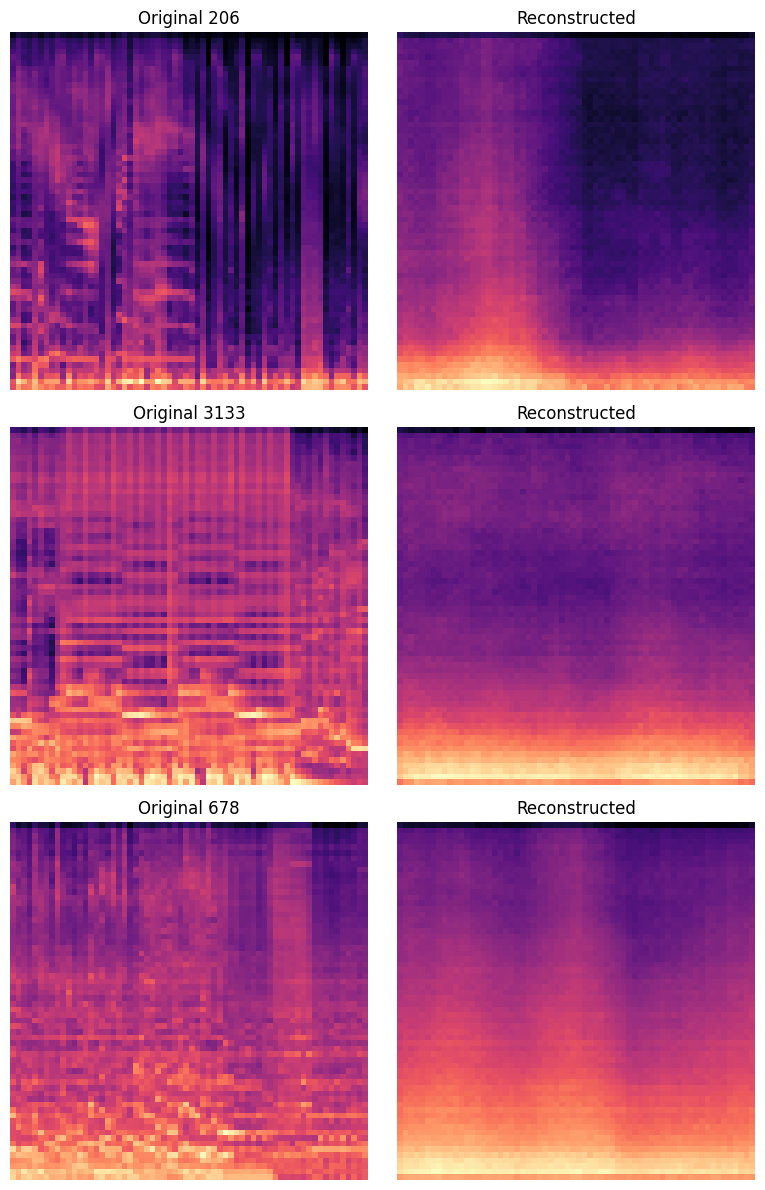

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import torch

# t-SNE
print("Generating t-SNE of Latent Space")
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
z_embedded = tsne.fit_transform(Z_cvae)

# decoding genre labels back to string
label_encoder_classes = np.load(os.path.join(DATA_DIR, 'X_genre_aligned.npy'))
genre_names = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'International', 'Jazz', 'Pop', 'Rock']
pred_labels = KMeans(n_clusters=len(np.unique(true_labels_idx)), random_state=42).fit_predict(Z_cvae)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_embedded[:, 0], z_embedded[:, 1], c=true_labels_idx, cmap='tab10', alpha=0.6, s=15)
plt.colorbar(scatter, label='Genre ID')
plt.title("t-SNE of CVAE Latent Space (Colored by True Genre)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.savefig(os.path.join(RESULTS_DIR, 'tsne_latent_genre.png'))
plt.show()

#  RECONSTRUCTION
print("Visualizing Reconstructions")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if 'final_model' in locals():
    final_model.eval()

    indices = np.random.choice(len(X_audio), 3, replace=False)

    img_sample = torch.FloatTensor(X_audio[indices]).to(device)
    txt_sample = torch.FloatTensor(X_text[indices]).to(device)
    lbl_sample = torch.FloatTensor(X_genre_onehot[indices]).to(device)

    with torch.no_grad():
        recon, _, _ = final_model(img_sample, txt_sample, lbl_sample)

    img_sample = img_sample.cpu().numpy()
    recon = recon.cpu().numpy()

    fig, axes = plt.subplots(3, 2, figsize=(8, 12))
    for i in range(3):
        # Original
        axes[i, 0].imshow(img_sample[i, 0], cmap='magma', origin='lower')
        axes[i, 0].set_title(f"Original {indices[i]}")
        axes[i, 0].axis('off')

        # Reconstruction
        axes[i, 1].imshow(recon[i, 0], cmap='magma', origin='lower')
        axes[i, 1].set_title(f"Reconstructed")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'reconstructions.png'))
    plt.show()
else:
    print("Error")